# DATA UNDERSTANDING


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
nltk.download('punkt')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# create column names
col_names = ['ID', 'Entity', 'Sentiment', 'Content']
# load the data
df = pd.read_csv('twitter_training.csv', names=col_names)
df.head()

,ID,Entity,Sentiment,Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
# basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Entity     74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [5]:
# Check Data Dimensions
df.shape


(74682, 4)

In [6]:
df.dtypes

ID            int64
Entity       object
Sentiment    object
Content      object
dtype: object

# DATA PREPARATION

In [7]:
# check for missing values
df.isnull().sum()

ID             0
Entity         0
Sentiment      0
Content      686
dtype: int64

In [8]:
# dropping the rows with content missing values
df.dropna(subset = ['Content'],inplace=True)

In [9]:
# Count the total number of duplicate rows
total_duplicates = df[df.duplicated(keep='first')].shape[0]

print("Total duplicate rows:", total_duplicates)

Total duplicate rows: 2340


In [10]:
# Drop duplicate rows
df.drop_duplicates(keep='first', inplace=True)

# Reset the index after dropping duplicates
df.reset_index(drop=True, inplace=True)


In [11]:
# replace irrelevant to neutral
df['Sentiment'] = df['Sentiment'].replace('Irrelevant', 'Neutral')

## EXPLORATARY DATA ANALYSIS

#### sentiment distribution

In [12]:
df.Sentiment.unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

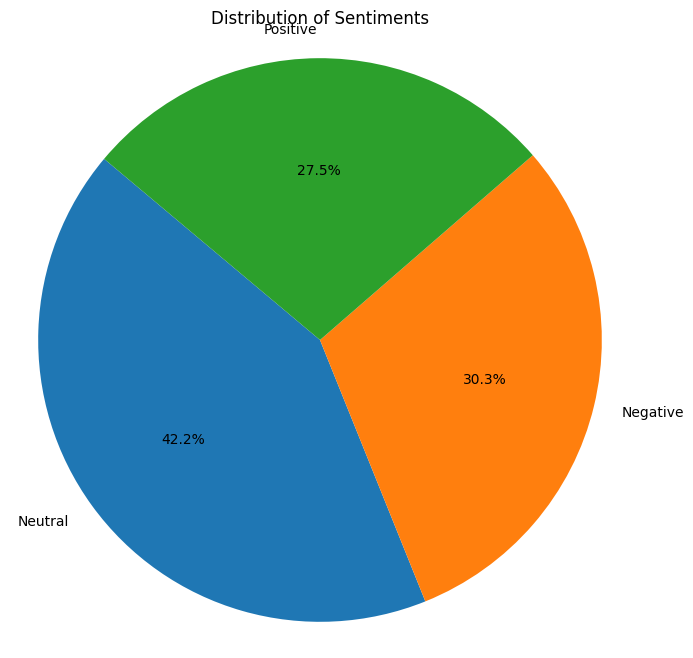

In [13]:
# Calculate the distribution of sentiments
sentiment_distribution = df['Sentiment'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiments')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.

# Show the pie chart 42.2
plt.show()

#### The sentiment distribution is relatively balanced, with neutral sentiments being the most common. This analysis can guide actions such as engaging with neutral sentiments, addressing negative sentiments, and leveraging positive sentiments for marketing and brand promotion.

#### Distribution of entity

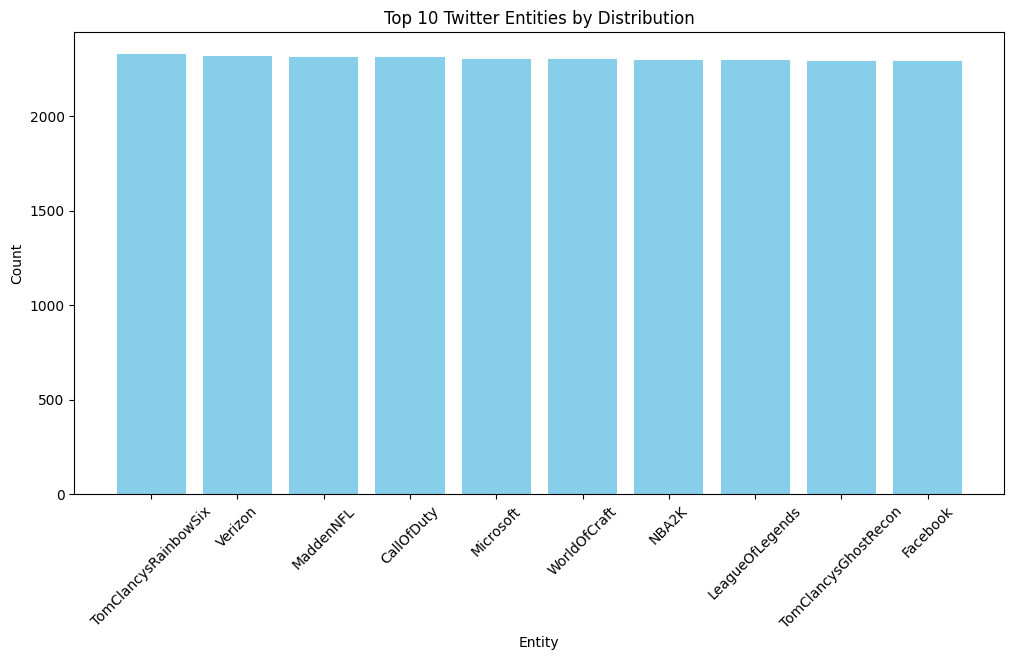

In [14]:
# Calculate the distribution of entities
entity_distribution = df['Entity'].value_counts()

# Select the top 10 entities
top_10_entities = entity_distribution.head(10)

# Create a bar chart for the top 10 entities
plt.figure(figsize=(12, 6))
plt.bar(top_10_entities.index, top_10_entities.values, color='skyblue')
plt.title('Top 10 Twitter Entities by Distribution')
plt.xlabel('Entity')
plt.ylabel('Count')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the bar chart
plt.show()

#### sentiment distribution in top 3 entities

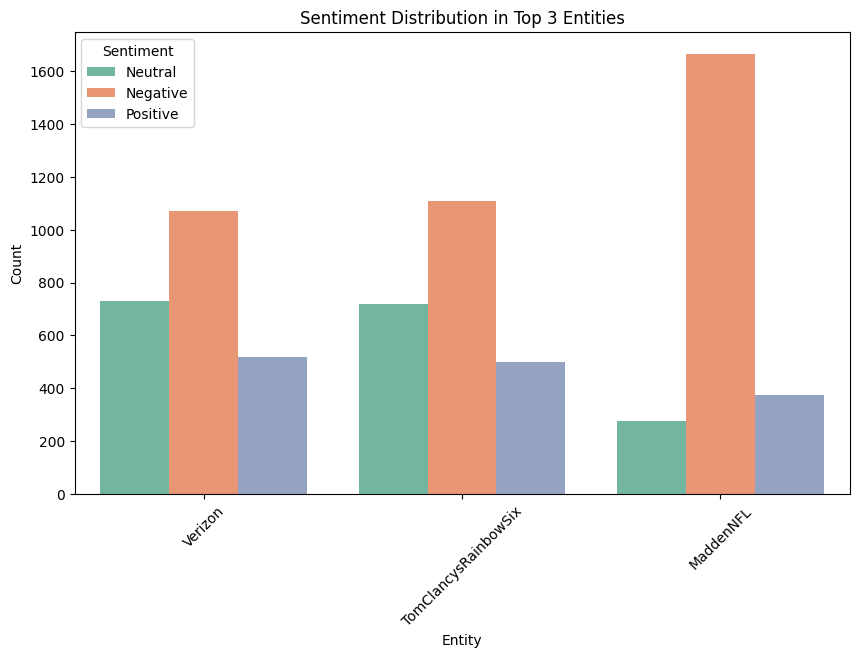

In [15]:
# Calculate the distribution of entities
entity_distribution = df['Entity'].value_counts()

# Select the top 3 entities
top_3_entities = entity_distribution.head(3).index

# Filter the DataFrame to include only the top 3 entities
df_top_3 = df[df['Entity'].isin(top_3_entities)]

# Create a grouped bar chart for sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top_3, x='Entity', hue='Sentiment', palette='Set2')
plt.title('Sentiment Distribution in Top 3 Entities')
plt.xlabel('Entity')
plt.ylabel('Count')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the grouped bar chart
plt.show()



#### sentiment distribution analysis

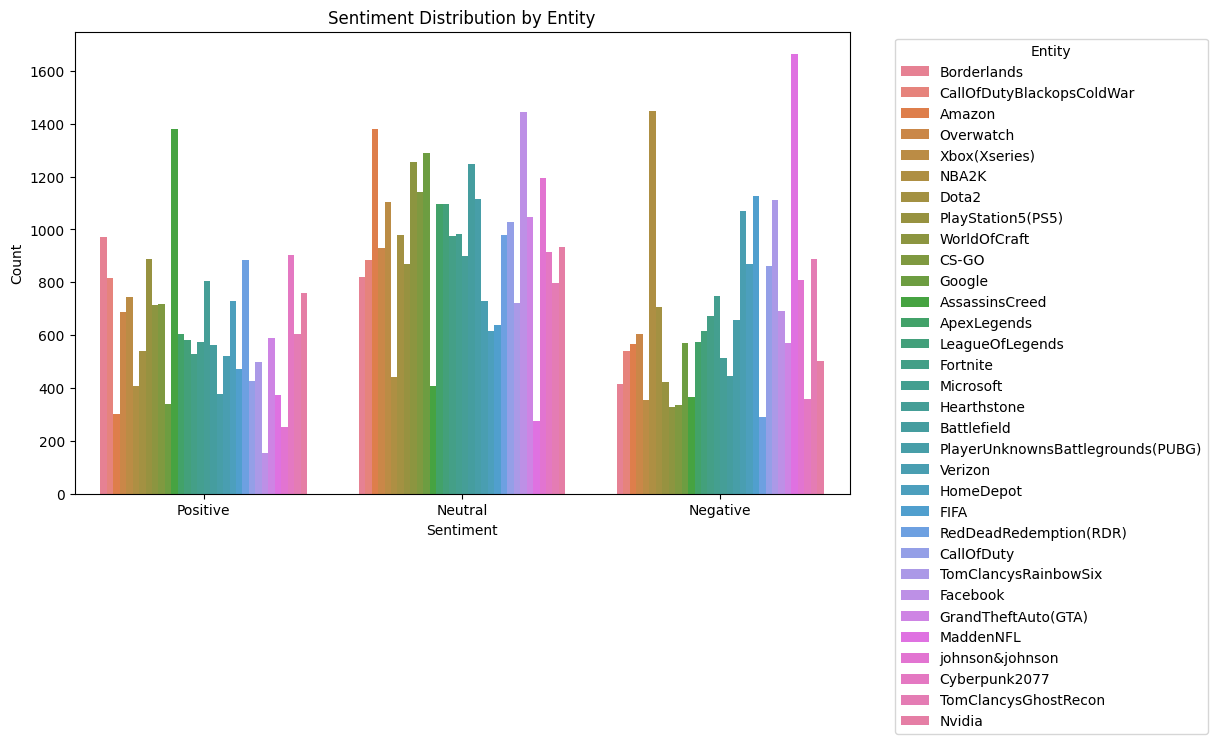

In [16]:
# Example for sentiment distribution by entity
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Sentiment', hue='Entity')
plt.title("Sentiment Distribution by Entity")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.legend(title='Entity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## TEXT ANALYSIS WITH NLP PROCESSING

#### NLP Preprocessing

In [17]:
# lets Load NLTK stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))

# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text with lemmatization and stopwords removal
def preprocess_text(text):
    # Remove special characters, numbers, and links
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()  # Convert to lowercase
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

# Apply preprocessing with lemmatization and stopwords removal to the 'Content' column
df['Cleaned_Content'] = df['Content'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


#### sentiment analysis

In [18]:
# loading vader to perform sentiment analysis
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer without specifying the lexicon file
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_scores(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

# Apply sentiment analysis to the 'Cleaned_Content' column
df['Sentiment_Score'] = df['Cleaned_Content'].apply(get_sentiment_scores)

# Categorize sentiment based on the compound score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment categorization
df['Sentiment_Predicted'] = df['Sentiment_Score'].apply(categorize_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


#### distribution of predicted sentiments

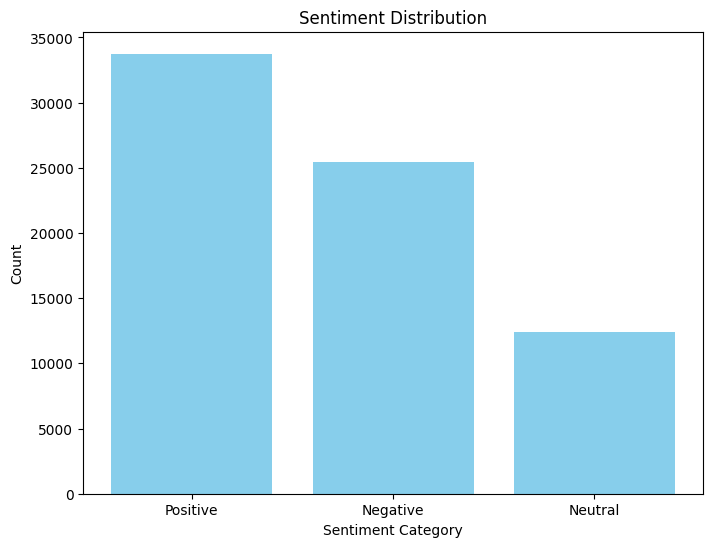

In [19]:
# lets Calculate the distribution of predicted sentiments
sentiment_distribution = df['Sentiment_Predicted'].value_counts()

# Create a bar chart for sentiment distribution
plt.figure(figsize=(8, 6))
plt.bar(sentiment_distribution.index, sentiment_distribution.values, color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')

# Show the bar chart
plt.show()

#### histogram of sentiment scores

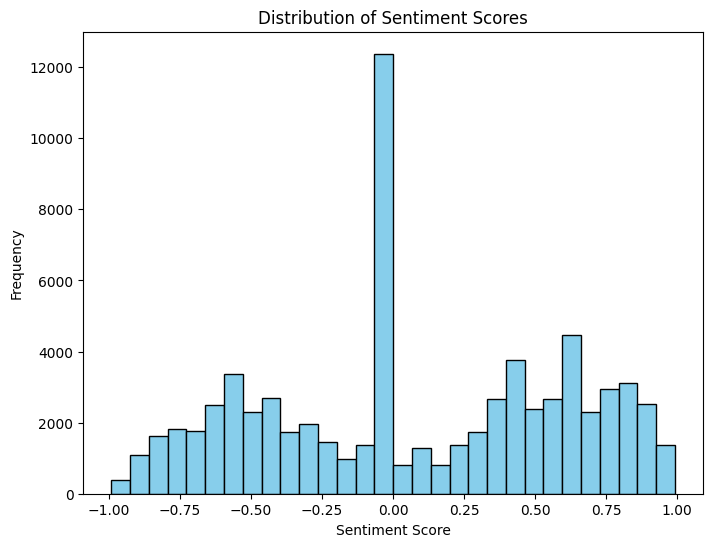

In [20]:
# Create a histogram of sentiment scores
plt.figure(figsize=(8, 6))
plt.hist(df['Sentiment_Score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

# Show the histogram
plt.show()

## Text data analysis

#### text length analysis

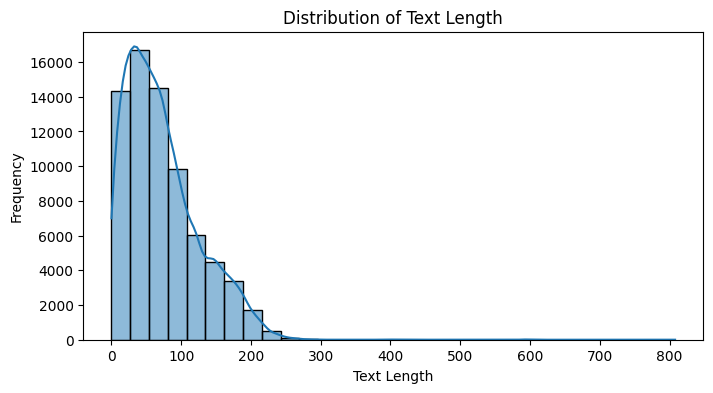

In [21]:
# for text length analysis
df['Text_Length'] = df['Cleaned_Content'].str.len()  # Calculate text length
plt.figure(figsize=(8, 4))
sns.histplot(df['Text_Length'], bins=30, kde=True)
plt.title("Distribution of Text Length")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()


#### word frequency analysis

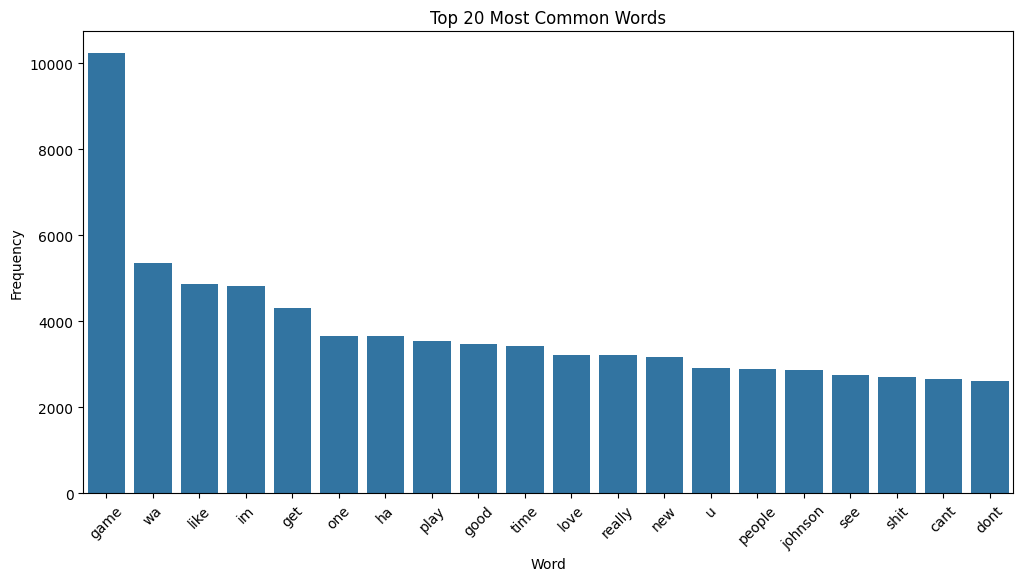

In [22]:
# word frequency analysis
from collections import Counter

words = ' '.join(df['Cleaned_Content']).split()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)

# Plot the top N most common words
plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in most_common_words], y=[word[1] for word in most_common_words])
plt.title("Top 20 Most Common Words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


#### word cloud of lemmatized social media

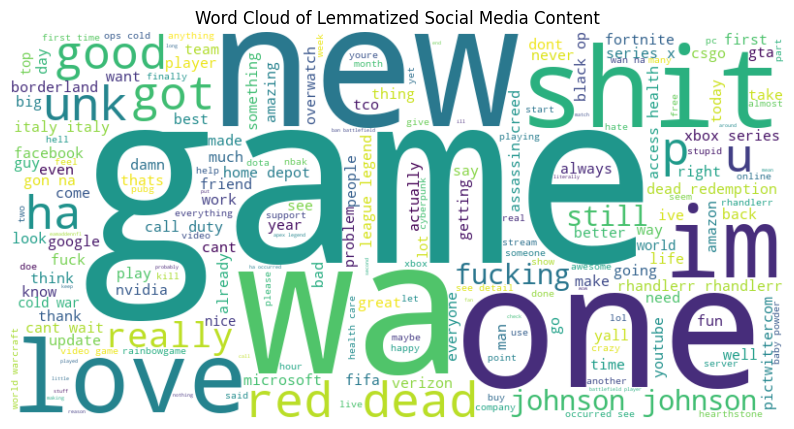

In [23]:
# Join the lemmatized content into a single string
text_data_lemmatized = ' '.join(df['Cleaned_Content'].dropna())
# Generate a word cloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data_lemmatized)
# plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Lemmatized Social Media Content")
plt.show()

#### word cloud for positive sentiment

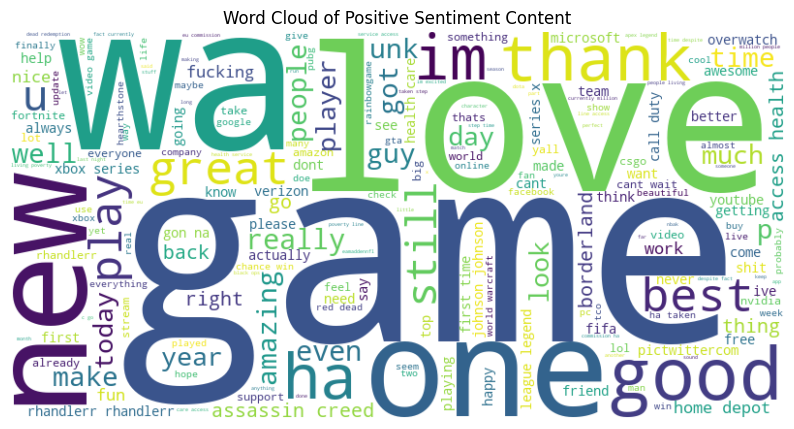

In [24]:
# Filter data for positive sentiment
positive_data = df[df['Sentiment_Predicted'] == 'Positive']

# Combine all lemmatized text for positive sentiment
positive_text_data = ' '.join(positive_data['Cleaned_Content'].dropna())

# Generate a word cloud for positive sentiment
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text_data)

# Display the word cloud for positive sentiment
plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Positive Sentiment Content")
plt.show()


#### word cloud for negetive sentiment

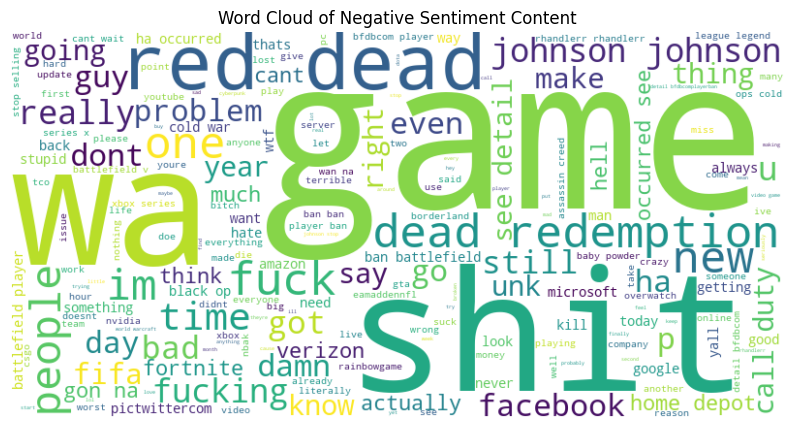

In [25]:
# lets Filter data for negative sentiment
negative_data = df[df['Sentiment_Predicted'] == 'Negative']

# Combine all lemmatized text for negative sentiment
negative_text_data = ' '.join(negative_data['Cleaned_Content'].dropna())

# Generate a word cloud for negative sentiment
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text_data)

# Display the word cloud for negative sentiment
plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Negative Sentiment Content")
plt.show()

#### word cloud for nuetral sentiment

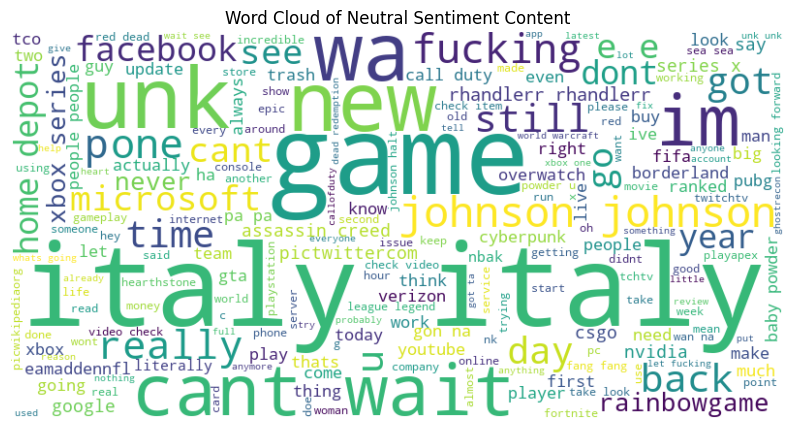

In [26]:
# lets Filter data for neutral sentiment
neutral_data = df[df['Sentiment_Predicted'] == 'Neutral']

# Combine all lemmatized text for neutral sentiment
neutral_text_data = ' '.join(neutral_data['Cleaned_Content'].dropna())

# Generate a word cloud for neutral sentiment
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text_data)

# Display the word cloud for neutral sentiment
plt.figure(figsize=(10, 6))
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Neutral Sentiment Content")
plt.show()